Moshe Kashlinsky,
Jonatan Yang, Aditya Gupta, Varsh Devired

**VARSH INTRODUCTION GOES HERE**

**ADITYA START HERE**

We first are going to import all our necessary libraries:

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

c:\Users\kashl\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Next, we import the databases from CSVs

In [ ]:
fed_df = pd.read_csv("Raw Data/Federal Reserve/index.csv")
print(fed_df.head(10).to_markdown())

|    |   Year |   Month |   Day |   Federal Funds Target Rate |   Federal Funds Upper Target |   Federal Funds Lower Target |   Effective Federal Funds Rate |   Real GDP (Percent Change) |   Unemployment Rate |   Inflation Rate |
|---:|-------:|--------:|------:|----------------------------:|-----------------------------:|-----------------------------:|-------------------------------:|----------------------------:|--------------------:|-----------------:|
|  0 |   1954 |       7 |     1 |                         nan |                          nan |                          nan |                           0.8  |                         4.6 |                 5.8 |              nan |
|  1 |   1954 |       8 |     1 |                         nan |                          nan |                          nan |                           1.22 |                       nan   |                 6   |              nan |
|  2 |   1954 |       9 |     1 |                         nan |                 

Find how much of everything is missing:

In [ ]:
missing = fed_df.isnull().sum()
print(missing)

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate    152
Real GDP (Percent Change)       654
Unemployment Rate               152
Inflation Rate                  194
dtype: int64


Seems like quite a bit...

All we need to fix is the effective rate, the unemployment and inflation. We need to do only this since those are the main things that we will be looking into. The Target, Upper and Lower rates are simply metrics that we will use to compute the effective rate, and Real GDP is by far mostly Null so is useless to us. Lets get fixing.

First, lets fix the Target Rate. We will either replace it with the target rate, or the average of the upper and lower rate depending on what we have.

In [ ]:
print(fed_df[pd.isnull(fed_df['Effective Federal Funds Rate'])].to_markdown())

# We can see from here that there are two cases: Either we have a target rate, or we have an upper and lower rate. We will calculate the federal funds rate as follows
# If we have the case of a Target Rate, set the effective rate to the target rate
# If we have the case of an upper and lower target, set the effective rate to the mean of the two.

debugList = fed_df[pd.isna(fed_df['Effective Federal Funds Rate']) & pd.isna(fed_df['Federal Funds Target Rate'])]

def fixEffectiveFundsRate(series):
    naArray = pd.isna(series)
    if(naArray['Effective Federal Funds Rate']):
        if(not naArray['Federal Funds Target Rate']):
            return series['Federal Funds Target Rate']
        elif(not(naArray['Federal Funds Upper Target'] or naArray['Federal Funds Lower Target'])):
            #print((series['Federal Funds Upper Target'] + series['Federal Funds Lower Target'])/2)
            return (series['Federal Funds Upper Target'] + series['Federal Funds Lower Target'])/2
        return "ERROR PLEASE EXAMINE"
    return series['Effective Federal Funds Rate']

fed_df['Effective Federal Funds Rate'] = fed_df.apply(fixEffectiveFundsRate, axis=1)

print("\n")

|     |   Year |   Month |   Day |   Federal Funds Target Rate |   Federal Funds Upper Target |   Federal Funds Lower Target |   Effective Federal Funds Rate |   Real GDP (Percent Change) |   Unemployment Rate |   Inflation Rate |
|----:|-------:|--------:|------:|----------------------------:|-----------------------------:|-----------------------------:|-------------------------------:|----------------------------:|--------------------:|-----------------:|
| 339 |   1982 |       9 |    27 |                     10.25   |                       nan    |                       nan    |                            nan |                         nan |                 nan |              nan |
| 341 |   1982 |      10 |     7 |                      9.5    |                       nan    |                       nan    |                            nan |                         nan |                 nan |              nan |
| 343 |   1982 |      11 |    19 |                      9      |            

Next, Unemployment. We will fix this via mode imputation now that we have a series with no Null values (Effective Federal Funds Rate)

In [ ]:
print(fed_df[pd.isnull(fed_df['Unemployment Rate'])].to_markdown())
print('\n')
#We see that for every null unemployment, we have a null inflation as well. The only nonnull we have consistently is effective rate. The other non-null rates are the target, the lower and upper rate, but we only either have target or upper+lower.
# I will use Mode Imputation to fill in the unemployments based on Effective Federal Funds Rate

grouped_unemployments = fed_df.groupby(['Effective Federal Funds Rate'])['Unemployment Rate'].apply(pd.Series.mode)
test = (grouped_unemployments.to_dict())
ordered_dict = {}
for i in test:
    if(i[0] not in ordered_dict):
        ordered_dict[i[0]] = []
    else:
        if(test[i] in ordered_dict[i[0]]):
            print("ERROR")
        ordered_dict[i[0]].append(test[i])

for i in fed_df['Effective Federal Funds Rate']:
    if(i in ordered_dict):
        pass
        #print(ordered_dict[i])
    else:
        ordered_dict[i] = []

for i in list(ordered_dict):
    if(ordered_dict[i]==[]):
        del ordered_dict[i]


def findClosestKey(dictionary,inputKey):
    if(inputKey in dictionary):
        return inputKey
    keys = dictionary.keys()
    toReturn = None
    for key in keys: # iterate through each key
        if(toReturn == None):
            toReturn = key
        if(abs(inputKey-key) < abs(inputKey-toReturn)): # if the current key is closer than our supposed closest, set this one as closest
            toReturn = key # set out new closest
    return toReturn

def fixUnemployment(series):
    naArray = pd.isna(series)
    if(naArray['Unemployment Rate']):
        key = findClosestKey(ordered_dict,series['Effective Federal Funds Rate'])
        return (sum(ordered_dict[key])/len(ordered_dict[key]))
    return series['Unemployment Rate']

fed_df['Unemployment Rate'] = fed_df.apply(fixUnemployment, axis=1)

|     |   Year |   Month |   Day |   Federal Funds Target Rate |   Federal Funds Upper Target |   Federal Funds Lower Target |   Effective Federal Funds Rate |   Real GDP (Percent Change) |   Unemployment Rate |   Inflation Rate |
|----:|-------:|--------:|------:|----------------------------:|-----------------------------:|-----------------------------:|-------------------------------:|----------------------------:|--------------------:|-----------------:|
| 339 |   1982 |       9 |    27 |                     10.25   |                       nan    |                       nan    |                        10.25   |                         nan |                 nan |              nan |
| 341 |   1982 |      10 |     7 |                      9.5    |                       nan    |                       nan    |                         9.5    |                         nan |                 nan |              nan |
| 343 |   1982 |      11 |    19 |                      9      |            

And Finally, Inflation. We have two series with no null values, so we will now use mode imputation to fix inflation. Since we have two columns and there may not be an exact match, we will use euclidian distance to find the MOST SIMILAR value to the inputted one.

In [ ]:
grouped_inflation = fed_df.groupby(['Effective Federal Funds Rate','Unemployment Rate'])['Inflation Rate'].agg(pd.Series.mode)
for index, value in grouped_inflation.items():
    if(value.size==0):
        grouped_inflation.pop(index)

def findNearestPoint(lst, input):
    distances = lst.index.map(lambda x: distance(x, input))
    return np.argmin(distances)

def distance(indexOne, indexTwo):
    return np.sqrt(sum((a - b) ** 2 for a, b in zip(indexOne, indexTwo)))

def fixInflation(series):
    naArray = pd.isna(series)
    if(naArray['Inflation Rate']):
        index = findNearestPoint(grouped_inflation, (series['Effective Federal Funds Rate'],series['Unemployment Rate']))
        result = grouped_inflation.iat[index]
        if(type(result)==np.ndarray):
            result = sum(result)/len(result)
        return result
    return series['Inflation Rate']

fed_df['Inflation Rate'] = fed_df.apply(fixInflation, axis=1)

Now we verify that there are no more nulls in our desired categories

In [ ]:
missing = fed_df.isnull().sum()
print(missing)

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate      0
Real GDP (Percent Change)       654
Unemployment Rate                 0
Inflation Rate                    0
dtype: int64


We have verified that in the Effective FF Rate category, Unemployment and Inflation categories we have no more null values. The data is cleaned, and let us now examine it.

First, lets plot out a box and whisker plot of each of the three series we have cleaned and see what we find:

{'whiskers': [<matplotlib.lines.Line2D at 0x209aebdcbd0>,
 'caps': [<matplotlib.lines.Line2D at 0x209c0367410>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c0364bd0>],
 'medians': [<matplotlib.lines.Line2D at 0x209c0370bd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x209bfce2350>],
 'means': []}

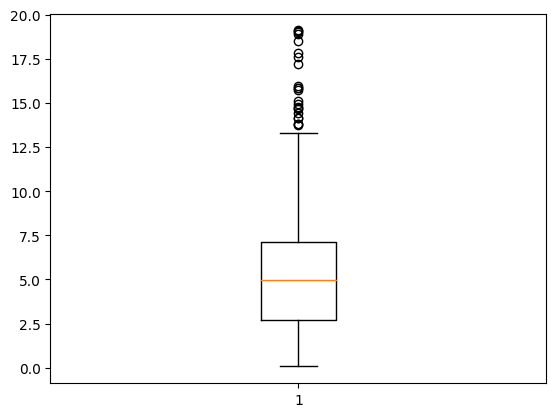

In [ ]:
import matplotlib.pyplot as plt
plt.boxplot(fed_df['Effective Federal Funds Rate'])

We can clearly see that there are several outliers, starting a little after 12.5 - this could cause us a few issues, but they are also authentic datapoints, and dropping them could give us inaccurate results

{'whiskers': [<matplotlib.lines.Line2D at 0x209c043e210>,
 'caps': [<matplotlib.lines.Line2D at 0x209c043fad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c043d5d0>],
 'medians': [<matplotlib.lines.Line2D at 0x209c0448f50>],
 'fliers': [<matplotlib.lines.Line2D at 0x209bf5caf50>],
 'means': []}

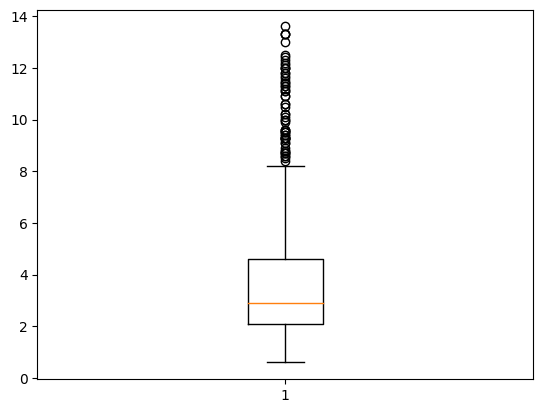

In [ ]:
plt.boxplot(fed_df['Inflation Rate'])

We can see that inflation has some more outliers, going from 8-14. Again, these are authentic datapoints, and there is a worry of dropping them leading to problems later with hypothesis testing

{'whiskers': [<matplotlib.lines.Line2D at 0x209c04a3090>,
 'caps': [<matplotlib.lines.Line2D at 0x209c04b0910>,
 'boxes': [<matplotlib.lines.Line2D at 0x209c04a2450>],
 'medians': [<matplotlib.lines.Line2D at 0x209c04b1f50>],
 'fliers': [<matplotlib.lines.Line2D at 0x209c04a3c10>],
 'means': []}

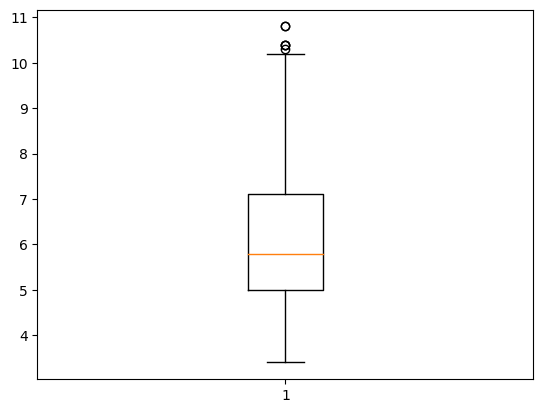

In [ ]:
plt.boxplot(fed_df['Unemployment Rate'])

Finally, we can see that unemployment has surprisingly little outliers - dropping them wouldnt help much, but perhaps would ruin the integrity of the data, so we will choose not to drop them.

Let us now get a cursory look at how unemployment and inflation each relate to the federal funds rate, the crux of our examination. We will do this by plotting them together and seeing how the relative changes look

<AxesSubplot: xlabel='Year'>

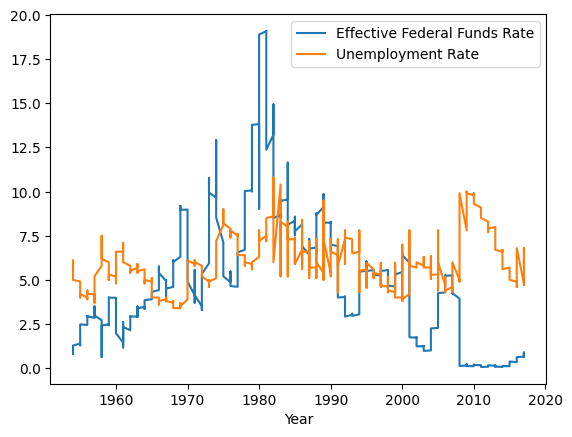

In [ ]:
fed_df.plot(x='Year',y=['Effective Federal Funds Rate','Unemployment Rate'],kind='line')

<AxesSubplot: xlabel='Year'>

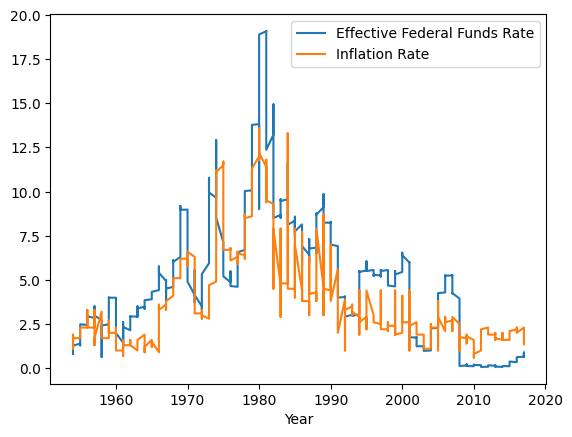

In [ ]:
fed_df.plot(x='Year',y=['Effective Federal Funds Rate','Inflation Rate'],kind='line')

At a cursory glance, it seems that inflation and the effective rate are very strongly related. One can see immediately that as the effective FF rate rises, so does the inflation rate. This shows a clear relation. However, unemployment does not seem as strongly related, and will need a more in depth review to see what exactly is going on under the hood. With the exception of after the 2008 recession, the data looks like it could have a relationship, albeit weaker than inflation,

Next, lets plot the data out in a scatterplot to see how it looks like from that perspective

<AxesSubplot: xlabel='Effective Federal Funds Rate', ylabel='Inflation Rate'>

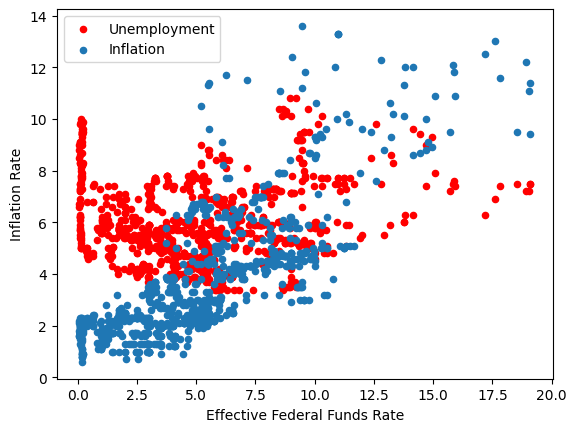

In [ ]:
ax = fed_df.plot.scatter(x='Effective Federal Funds Rate',y='Unemployment Rate',color='red',label='Unemployment',legend=True)
fed_df.plot.scatter(x='Effective Federal Funds Rate',y='Inflation Rate',label='Inflation',legend=True,ax=ax)

So we notice several things from this scatterplot. Firstly, we notice that there is a significant zero inflation in our data. Many of the values are clustered at FF=0, and this influences everything from our mean to our standard deviation, and potentially impacts models. Below, lets see how many value at zero there are. Keep in mind we only have 903 values in our entire table.

In [ ]:
fed_df[fed_df['Effective Federal Funds Rate']==0].shape[0]

0

Interesting! While we dont seem to have ANY values at x=0, we have many which are still almost 0. What if we do a check where values are <0.25?

In [ ]:
fed_df[fed_df['Effective Federal Funds Rate']<=0.25].shape[0]

86

Now we see that we have 86 values with FF rates below 0.25, almost 10% of our data, we can see that we have a huge bias here. But how about the outliers? We can clearly see that the vast majority of the datapoints are with a federal funds rate below 12.5, but thaere are some that are almost 20. However, just by a quick inspection, we can see that the outliers are not too significant. Most of the points that are far out are following the general trend, so the only points that are really outliers are not going to have too much of an impact. This may or may not be a boundary condition, since it is not exactly zero, but it does tend to cluster there.

**ADITYA END HERE, JONATHAN START HERE**

***NOTES FROM JONATHAN, DELETE WHEN SUBMITTING:***
***Assuming no crossreferencing the earlier portions of the document is needed, I have finished the commentary on this section. I have not added any GIFs or improved the code aside from additional comments.***

Before we run any hypothesis tests, we can see clearly that there is a correlation between inflation and the federal funds rate. But the unemployment rate seems to be less obviously correlated. At first glance, the two groups appear disparate, with a slight positive, albeit noisy, correspondence. This seems to be in line with common conceptions of the the federal funds rate and its relation with the economy as a whole. Let's do hypothesis testing and see how they are related here statistically.



> H0 - The Federal Funds Rate has NO impact on the Unemployment Rate




> HA - The Federal Funds Rate DOES have an impact on the Unemployment Rate

In this evaluation we shall use an alpha value of 0.05.



(45187.31893682355, 1.692741910395266e-73, 39858, array([[0.04977876, 0.04424779, 0.00553097, ..., 0.00553097, 0.01659292,
        0.01106195],
       [0.06969027, 0.0619469 , 0.00774336, ..., 0.00774336, 0.02323009,
        0.01548673],
       [0.12942478, 0.11504425, 0.01438053, ..., 0.01438053, 0.04314159,
        0.02876106],
       ...,
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239],
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239],
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239]]))


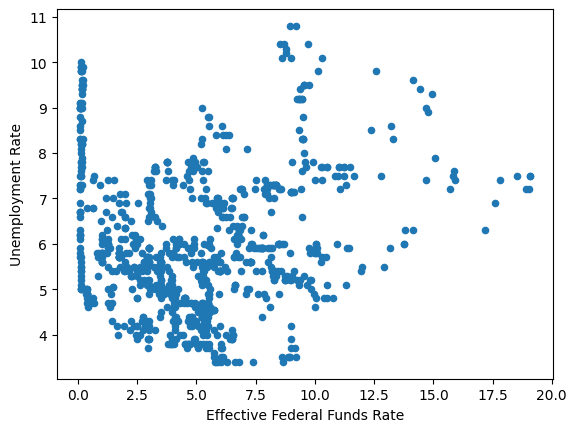

In [ ]:
unemployment_crosstable = pd.crosstab(fed_df['Effective Federal Funds Rate'], fed_df['Unemployment Rate'])
result = stats.chi2_contingency(unemployment_crosstable)
print(result) # the 2nd value is the p value
unemployment_plot = fed_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Unemployment Rate')

The p value for here is miniscule, implying that the two values are strongly related. The spike of zero-valued fund rates is visually denoted in the plot, forming a vertical bar across nearly the entire band of unemployment rates, and is a possible confounding variable we shall address shortly. Aside from this the plot describes a number of other more loosely correlated vertical patterns when the fund rate is approximately 3 and 9 percent respectively, though it is more difficult to draw any substantial conclusions if we consider them as outliers. Barring any further analysis, of course, what appears to be a tentative positive correlation visually persists.

Under mode imputation, since a p-value of $~1.7*10^{-73}$ is significantly less than alpha (0.05), we may reject the null hypothesis, taking the alternative hypothesis as its replacement. Now, let us test inflation the same way.



> H0 - The Federal Funds Rate has NO impact on the Inflation Rate

> HA - The Federal Funds Rate DOES have an impact on the Inflation Rate



(72221.00072380164, 0.0, 54677, array([[0.00553097, 0.01106195, 0.01659292, ..., 0.00553097, 0.01659292,
        0.00553097],
       [0.00774336, 0.01548673, 0.02323009, ..., 0.00774336, 0.02323009,
        0.00774336],
       [0.01438053, 0.02876106, 0.04314159, ..., 0.01438053, 0.04314159,
        0.01438053],
       ...,
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00331858,
        0.00110619],
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00331858,
        0.00110619],
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00331858,
        0.00110619]]))


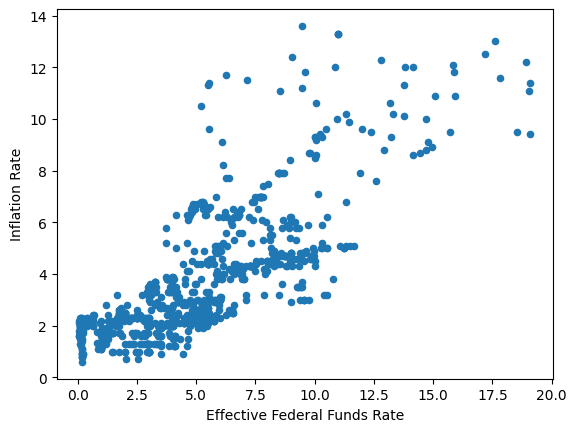

In [ ]:
inflation_crosstable = pd.crosstab(fed_df['Effective Federal Funds Rate'], fed_df['Inflation Rate'])
result = stats.chi2_contingency(inflation_crosstable)
print(result) # the 2nd value is the p value
inflation_plot = fed_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Inflation Rate')

The p value for here is the perfect positive correlation of zero (0.0), implying that the two values are strongly related. Unlike its counterpart scatterplot with unemployment rates, the federal funds rate has a less pronounced vertical bar of values near the origin, and a far more defined positive linear trend. Though we shall consider and address its zero values as a possible confounder in the following sections, an undeniable correlation remains as expected.

Under mode imputation, since the p-value (0.0) is less than that of alpha (0.05), we may reject the null hypothesis and take the alternative hypothesis as its replacement.

We turn our attention to the problem of zero-value fund rate data points, and its possible presence as a confounding variable when determining a correlating relation between datasets.
Mode imputation is a powerful tool assuming a continuous distribution with a strong emphasis on the majority. In our analysis thus far, this has been our working assumption, and the data has been processed with mode imputation. However, it may introduce heavy biases when any outliers are involved, as any NaN/null entries corresponding to one will simply duplicate outlying values with no regard to the rest of the data, resulting in misleading spikes. This is one possible explanation for the vertical bars around certain values in our plots, most notably around the origin. In light of this, we must test our hypotheses again, either with a number of different imputation methods or by simply dropping the offending NaN/null values.

First, we will try the simple approach. Let us try to drop Null values instead of imputing them and see if this affects our hypothesis testing. This time, we begin with the inflation rate.

In [ ]:
fed_nonnull_df = pd.read_csv("Raw Data/Federal Reserve/index.csv")
fed_nonnull_df = fed_nonnull_df.dropna(subset=['Effective Federal Funds Rate','Unemployment Rate','Inflation Rate'])
print(fed_nonnull_df.isnull().sum())


Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       395
Federal Funds Upper Target      612
Federal Funds Lower Target      612
Effective Federal Funds Rate      0
Real GDP (Percent Change)       474
Unemployment Rate                 0
Inflation Rate                    0
dtype: int64


We have verified that we have no more null values in our desired columns (Effective Federal Funds Rate, Unemployment Rate and Inflation Rate), so let us conduct hypothesis testing here.



> H0 - The Federal Funds Rate has NO impact on the Inflation Rate


> HA - The Federal Funds Rate DOES have an impact on the Inflation Rate

As before, we set an alpha value of 0.05.



(54625.57824755772, 5.408463068011238e-144, 46410, array([[0.00704225, 0.01408451, 0.02112676, ..., 0.00704225, 0.00704225,
        0.00704225],
       [0.00985915, 0.01971831, 0.02957746, ..., 0.00985915, 0.00985915,
        0.00985915],
       [0.01830986, 0.03661972, 0.05492958, ..., 0.01830986, 0.01830986,
        0.01830986],
       ...,
       [0.00140845, 0.0028169 , 0.00422535, ..., 0.00140845, 0.00140845,
        0.00140845],
       [0.00140845, 0.0028169 , 0.00422535, ..., 0.00140845, 0.00140845,
        0.00140845],
       [0.00140845, 0.0028169 , 0.00422535, ..., 0.00140845, 0.00140845,
        0.00140845]]))


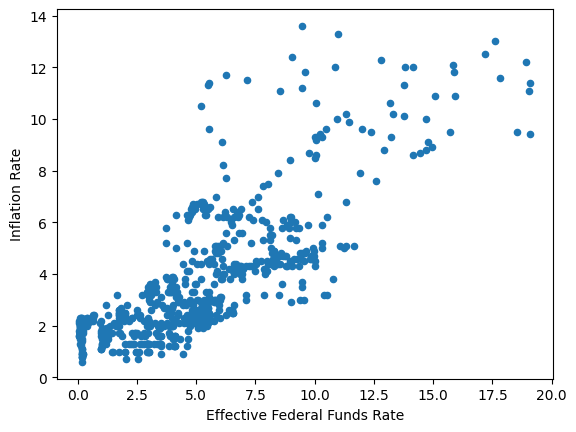

In [ ]:
inflation_second_crosstable = pd.crosstab(fed_nonnull_df['Effective Federal Funds Rate'], fed_nonnull_df['Inflation Rate'])
result = stats.chi2_contingency(inflation_second_crosstable)
print(result) # the 2nd value is the p value
inflation_second_plot = fed_nonnull_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Inflation Rate')

The p value for here is incredibly miniscule, implying that the two values are strongly correlated, as we found in our earlier analysis. The plot retains much of its visual appearance, including the spike at the origin. Unlike before, we may safely conclude that this is not an artifact of preprocessing but a property of the data itself. A subsequent analysis of the same pattern but with unemployment instead will elucidate its presence here.

Dropping null values, because p ($5.4*10^{-144}$) is less than alpha (0.05), we can confidently reject the null hypothesis and take the alternative hypothesis as its replacement. Now, let us test unemployment the same way.

> H0 - The Federal Funds Rate has NO impact on the Unemployment Rate

> HA - The Federal Funds Rate DOES have an impact on the Unemployment Rate
alpha = 0.05

(30520.626727085353, 0.954569245406529, 30940, array([[0.06338028, 0.05633803, 0.00704225, ..., 0.00704225, 0.02112676,
        0.01408451],
       [0.08873239, 0.07887324, 0.00985915, ..., 0.00985915, 0.02957746,
        0.01971831],
       [0.16478873, 0.14647887, 0.01830986, ..., 0.01830986, 0.05492958,
        0.03661972],
       ...,
       [0.01267606, 0.01126761, 0.00140845, ..., 0.00140845, 0.00422535,
        0.0028169 ],
       [0.01267606, 0.01126761, 0.00140845, ..., 0.00140845, 0.00422535,
        0.0028169 ],
       [0.01267606, 0.01126761, 0.00140845, ..., 0.00140845, 0.00422535,
        0.0028169 ]]))


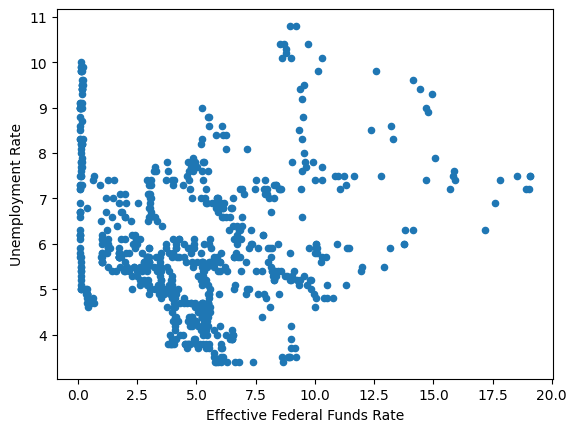

In [ ]:
unemployment_second_crosstable = pd.crosstab(fed_nonnull_df['Effective Federal Funds Rate'], fed_nonnull_df['Unemployment Rate'])
result = stats.chi2_contingency(unemployment_second_crosstable)
print(result) # the 2nd value is the p value
unemployment_second_plot = fed_nonnull_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Unemployment Rate')

The p value for here is surprising. It is roughly 0.95, implying that the null hypothesis is very strong when we drop null values. When dropping null values, since p (~0.95) is far greater than alpha (0.05), we can confidently fail to reject the null hypothesis and do not take the alternative hypothesis as its replacement.

With the non-null data from unemployment, it appears as if the slight positive trend is not enough to count as correlation. A visual comparison does not yield any insights. Why the dramatic 180? One possibility is that mode imputation did in fact create a significant bias in the data, but that it did not have a connection with the prominent data spikes located throughout the graph, as their patterns persist even when removing all invalid data.

(As an aside, it is notable that federal fund rates have only been near zero for two major incidents in recent history: the 2008 recession and the 2020 pandemic. This is why the zero-spike does not dip below 4% unemployment.)


So we have a consensus on inflation, but how about unemployment? We are 1 for 1, so let us try a third method of imputation, MICE Imputation, and then see what happens.

We will now try to break the tie and see whether unemployment is linked to the federal funds rate. We are changing up the process by cleaning data in a 3rd way, using MICE imputation. MICE imputation and other regressive ML algorithms have a reputation for accuracy, preserving the distribution which it predicts. Let us see how it works out.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=100, max_iter=10) # Default learning rates

fed_mice_df = pd.read_csv("Raw Data/Federal Reserve/index.csv")

fed_train_df = fed_mice_df.loc[:, ['Effective Federal Funds Rate', 'Unemployment Rate','Inflation Rate']]
imputer.fit(fed_train_df)
fed_imputed_df = imputer.transform(fed_train_df)
fed_mice_df.loc[:, ['Effective Federal Funds Rate', 'Unemployment Rate','Inflation Rate']] = fed_imputed_df
fed_mice_df.isnull().sum()

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate      0
Real GDP (Percent Change)       654
Unemployment Rate                 0
Inflation Rate                    0
dtype: int64

We have verified that we have no more null values in our desired columns (Effective Federal Funds Rate, Unemployment Rate and Inflation Rate), so let us conduct hypothesis testing here. In the interest of experimentation, let us also test inflation and see whether we confirm our previous findings.

> H0 - The Federal Funds Rate has NO impact on the Inflation Rate

> HA - The Federal Funds Rate DOES have an impact on the Inflation Rate

As before, we set an alpha value of 0.05.

(95713.51976280363, 0.0, 68502, array([[0.00553097, 0.01106195, 0.01659292, ..., 0.00553097, 0.00553097,
        0.00553097],
       [0.00774336, 0.01548673, 0.02323009, ..., 0.00774336, 0.00774336,
        0.00774336],
       [0.01438053, 0.02876106, 0.04314159, ..., 0.01438053, 0.01438053,
        0.01438053],
       ...,
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00110619,
        0.00110619],
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00110619,
        0.00110619],
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00110619,
        0.00110619]]))


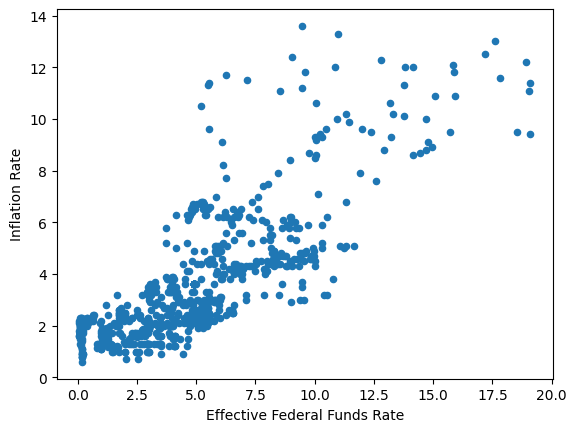

In [ ]:
inflation_third_crosstable = pd.crosstab(fed_mice_df['Effective Federal Funds Rate'], fed_mice_df['Inflation Rate'])
result = stats.chi2_contingency(inflation_third_crosstable)
print(result) # the 2nd value is the p value
inflation_third_plot = fed_mice_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Inflation Rate')

Confirming the last two tests, the p value for here indicates a perfect correlation, implying that the two values are related. Now, let us test unemployment the same way.

> H0 - The Federal Funds Rate has NO impact on the Unemployment Rate

> HA - The Federal Funds Rate DOES have an impact on the Unemployment Rate

(39705.819486285196, 1.2117909189757412e-129, 33086, array([[0.04977876, 0.04424779, 0.00553097, ..., 0.00553097, 0.01659292,
        0.01106195],
       [0.06969027, 0.0619469 , 0.00774336, ..., 0.00774336, 0.02323009,
        0.01548673],
       [0.12942478, 0.11504425, 0.01438053, ..., 0.01438053, 0.04314159,
        0.02876106],
       ...,
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239],
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239],
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239]]))


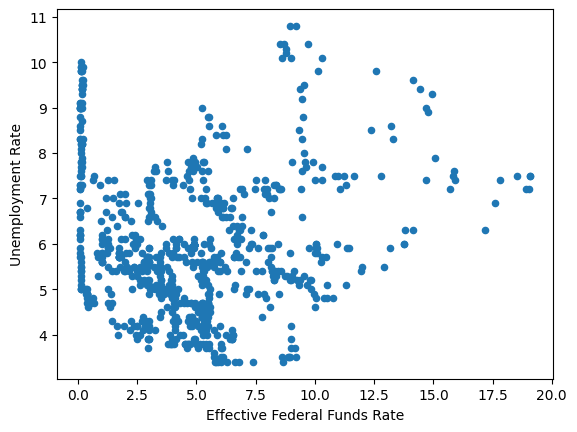

In [ ]:
unemployment_third_crosstable = pd.crosstab(fed_mice_df['Effective Federal Funds Rate'], fed_mice_df['Unemployment Rate'])
result = stats.chi2_contingency(unemployment_third_crosstable)
print(result) # the 2nd value is the p value
unemployment_third_plot = fed_mice_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Unemployment Rate')

The p value for here is tiny, implying that the two values are related. As before, a direct visual comparison yields no insight. Since p (~1.2*10^-129) is less than alpha (0.05), we should confidently reject the null hypothesis and take the alternative hypothesis as its replacement. However, this could just be due lack of information: overfitting on outliers can easily lead to a misleading conclusion, in much the same way as mode imputation.

In addition to this, we may need to reexamine our findings quantitatively. The Chi Square test delineates the relationship between two categorical variables; which for a visibly strong relationship such as the one between inflation and fund rates may function properly by sorting a small number of data points per 'category'; though the same might not be said if the data points are more randomly distributed.

To follow up, we shall use direct correlation testing across all datasets to conclusively determine whether there is a relationship or not between unemployment and the federal funds rate.

Let us now finally calculate the correlations of the federal funds rate to unemployment and inflation respectively. Here, we shall use the Pearson correlation method.

In [ ]:
print(f"Inflation: {fed_df['Effective Federal Funds Rate'].corr(fed_df['Inflation Rate'])}")
print(f"Unemployment 1: {fed_df['Effective Federal Funds Rate'].corr(fed_df['Unemployment Rate'])}")
print(f"Unemployment 2: {fed_nonnull_df['Effective Federal Funds Rate'].corr(fed_nonnull_df['Unemployment Rate'])}")
print(f"Unemployment 3: {fed_mice_df['Effective Federal Funds Rate'].corr(fed_mice_df['Unemployment Rate'])}")

Inflation: 0.775446895986523
Unemployment 1: 0.08917119453907305
Unemployment 2: -0.0016378031245195897
Unemployment 3: 0.03662592946489293


We can conclude here that the Federal Funds Rate has a VERY strong positive correlation to inflation. However, the results for unemployment are different. In all three methods of checking whether there is a correlation between the federal funds rate and unemployment, the correlation coefficient does not even get higher than ±0.1 - this implies that there is very little, if any correlation between the federal funds rate and unemployment.


This latest finding is in line with a visual analysis: it is not likely that the federal funds rate is as heavily correlated with unemployment as it is with inflation from a simple comparison! Instead, the imputation methods amplified the common data points enough that a categorical redistribution of the processed data points would easily result in a misleading high correlation. With a quantitative analysis through the Pearson method, we reach a more appropriate and intuitive final result.

In conclusion, based on our analysis of the data, there is a strong correlation between inflation and the federal funds rate, while there is little to no correlation between unemployment and the federal funds rate.

**JONATAN END HERE**

Machine Learning

Visualization

Conclusion (To be written after machine learning+visualization)